In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
# cd drive/My Drive/project2

<b>References:</b> \\
https://github.com/tmabraham/retinopathy-classifier \\
https://github.com/cauchyturing/kaggle_diabetic_RAM \\
https://becominghuman.ai/data-augmentation-on-gpu-in-tensorflow-13d14ecf2b19 \\
https://www.kaggle.com/meenavyas/diabetic-retinopathy-detection \\
https://www.kaggle.com/kmader/inceptionv3-for-retinopathy-gpu-hr \\
https://www.kaggle.com/bhargavbhatt/project-work \\





##Importing the required Libraries

In [4]:
import glob
import tensorflow as tf
import seaborn as sns  
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import os
from keras import backend as K
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from keras.applications.inception_v3 import preprocess_input
from keras.utils.np_utils import to_categorical as One_hot
from keras.layers import LeakyReLU, Dense, Dropout, Flatten, Input, Conv2D, Lambda, BatchNormalization, GlobalAveragePooling2D, multiply, LocallyConnected2D,MaxPooling2D
from keras.applications.vgg16 import VGG16 as model1
from keras.applications.inception_resnet_v2 import InceptionResNetV2 as model2
from keras.applications.inception_v3 import InceptionV3 as model3
from keras.models import Model



Using TensorFlow backend.


<h1>Reading the image labels<h1>

In [0]:
# reading the training labels csv file which would give us Dataframe consiiting of name of image and the level of DR respectively .
df = pd.read_csv('trainLabels.csv.zip')

#Splitting the image name by '_' as name is given as for example: "10_left" where left is the eye and 10 is the patient ID and storing in ID column
df['ID'] = df['image'].str.split("_", n = 0, expand = True)[0]
# df['image'].str.split("_", n = 0, expand = True)[1].hist()

<h2>Looking for images in the train1 folder according to the images label in df['image'] as some of the images may have been corrupted in the process of downloading and unzipping.<h2>


In [0]:
df["Not corrupted"]=("./input/train1/"+df['image']+".jpeg").map(os.path.isfile)

# Only considering the files that are not corrupted
df = df[df["Not corrupted"]==True]

#Column comprising of all the useful (Not corrupted) images
df['path'] = ("./input/train1/"+df['image']+".jpeg")


Visualizing the number of images according to the levels of DR associated to the them. \\
As we can see the <b>uneven distribution</b> of number of images for level 0 we might need ot take further sampling measures inorder to generate a dataset with equal distribution of number of images for all levels (0,1,2,3,4).

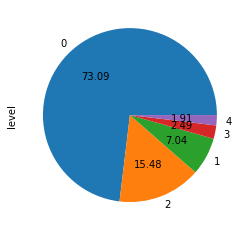

In [7]:
df.level.value_counts().plot(kind='pie',autopct='%.2f')

<b>One Hot encoding </b> of levels (0,1,2,3,4) for all images \\
Example One Hot encoding : \\
level : 1 \\
One Hot representation : [0,1,0,0,0]

In [7]:
df['One']=df['level'].map(lambda levels: One_hot(levels, 5))

# Checking for any Nan values
print(df[df.isna().any(axis=1)])

Empty DataFrame
Columns: [image, level, ID, Not corrupted, path, One]
Index: []


## Setting all the left and right eye Strings to 0 & 1 int.
Here left = 1 & right = 0 

In [0]:
def check(x):
  if(x=="left"):
    return 1
  else:
    return 0

In [0]:
df['position'] = df['image'].str.split("_", n = 0, expand = True)[1].map(lambda name : check(name))

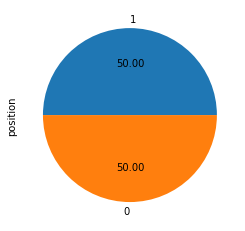

In [11]:

# Here we can see through the means of a pie diagram , the number of images for left and right eyes are equal
# But still the major problem of uneven samples for different levels still exsists, which might influence the accuracy of our model.
# fig, axes = plt.subplots(1, 2)
df.position.value_counts().plot(kind='pie',autopct='%.2f')
# df['position'].hist(ax=axes[0], color='green')


Droppping the duplicates present in the dataframe with ID and level of the patient as a grouped key for looking up for duplicates. \\


In [0]:
data = DataFrame.drop_duplicates(df[['ID','level']])

<h2>Further Splitting the dataset into traning and testing dataframes.</h2>

In [0]:

# Here mentionining of stratify parameter states that the level column is the label/output class
train, test = train_test_split(data,test_size = 0.20,stratify = data['level'])

In [0]:
#Splitting the entire big data frame into train and test frames based on the above statement
train_data = df[df['ID'].isin(train['ID'])]
test_data = df[df['ID'].isin(test['ID'])]


## Sampling the present image data inorder to bring all the image levels at equilibrium with each other.

In [0]:
# Here set replace to true as we generate huge number of  samples
def sample(instance):
  return instance.sample(120 ,replace =True)
train_X = train_data.groupby(['level', 'position']).apply(lambda x: sample(x)).reset_index(drop = True)

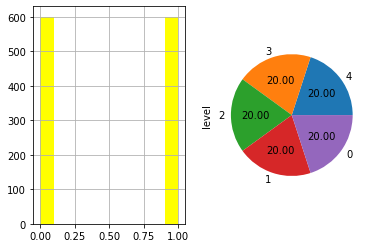

In [14]:
fig, axes = plt.subplots(1, 2)
train_X['position'].hist(ax=axes[0],color = 'yellow')

# train_X['level'].hist(ax=axes[1])
train_X.level.value_counts().plot(kind='pie',autopct='%.2f')

<h1>Functions for decoding, resizing, flipping, cropping, padding and changing of brightness, contrast, hue , saturation of training images<h2> 

In [0]:

#Function for reading and resize the image
def decode_and_resize(image,type_image ='rgb'):
  
  if(type_image=='rgb'):
    # print("Image is RGB")
    #channels = 3 signifies RGB
    # And reshaping image for output size (640,640)
    return tf.image.resize_images(tf.image.decode_jpeg(tf.read_file(image), channels = 3),(640,640))
  else:
    # Channels is set to 0 if image is not RGB
    # print("Image is  not RGB")
    return tf.image.resize_images(tf.image.decode_png(tf.read_file(image), channels = 0),(640,640))

#preprocessing of set of training images
def train_image_process(real_image,y):
  real_img_data =  decode_and_resize(real_image,type_image='rgb')
  real_img_data = tf.image.random_flip_left_right(real_img_data) #Randomly flip an image horizontally
  real_img_data = tf.image.random_flip_up_down(real_img_data) #Randomly flips an image vertically 
  real_img_data = tf.image.random_brightness(real_img_data, max_delta = 0.1) #Changes the brightness of images by a random multiple. max_delta specifies range[-max_delta,max_delta] 
  real_img_data = tf.image.random_saturation(real_img_data,upper = 1.2,lower = 0.65) #Adjust the saturation of images by a random multiple.
  real_img_data = tf.image.random_hue(real_img_data, max_delta = 0.10) #Adjust the hue of images by a random multiple.
  real_img_data = tf.image.random_contrast(real_img_data,upper = 1.2, lower = 0.65) #Adjust the contrast of an image by a random multiple.
  return preprocess_input(real_img_data),y

def image_sculpting(processed_image,y):
  # Generating values from random uniform distribution between -10 radians (lower bound) and +10 radians (upper bound)
  angle_range = tf.random_uniform([tf.shape(processed_image)[0]], -np.deg2rad(10), np.deg2rad(10))
  changes = []
  # provides us with projective transform for the given angle for given width=640 and height=640
  changes += [tf.contrib.image.angles_to_projective_transforms(angle_range, 640, 640)]
  if(len(changes)>=1):
    # Applies the given transformations to the image.
    processed_image = tf.contrib.image.transform(processed_image,tf.contrib.image.compose_transforms(*changes),interpolation="NEAREST")
    # Resizes images to the given height, width by either cropping or padding.
  processed_image = tf.image.resize_image_with_crop_or_pad(processed_image, 512, 512)
  return processed_image,y


#Runs all the above mentioned function on the images
def runAll(batch_size = 16):
    def stitch(ip):
        #Mapping of images to preprocessing and then sculpting function
        return (ip.map(train_image_process, num_parallel_calls=4).batch(batch_size)).map(image_sculpting)
    return stitch

In [0]:
#Validation/Testing images loader
def val_image_preproc(X,y):
  return preprocess_input(decode_and_resize(X)),y

#Runs all the desired functions on the validation images
def test_runAll(batch_size=16):
  def test_stitch(ip):
    return (ip.map(val_image_preproc, num_parallel_calls=4).batch(batch_size)).map(image_sculpting)
  return test_stitch

In [0]:
#Filters this dataset according to given subject
def dataset_form(a,b):
  return tf.data.Dataset.from_tensor_slices((a,b))

#Providing directory where images are stored
def train_data_preproc(curr):
  address = ("./input/train1/"+curr['image']+".jpeg").values

  #Joins the provided sequence along the new Axis
  position_pile =  np.stack(curr['One'].values,0)
  #Datatset formation
  images = dataset_form(address,position_pile)
  

  batch_size = 32
  #Running all the preprocessing steps
  idg = runAll( batch_size = batch_size )
  
  #Forming dataset iterators
  while 1:
    shuffled_images = images.shuffle(address.shape[0]) #Shuffling of images   
    dataset_temp = idg(shuffled_images).repeat()
    iterator = dataset_temp.make_one_shot_iterator()
    next_batch =iterator.get_next()
    for i in range(max(df['path'].values.shape[0]//batch_size,1)):
      yield K.get_session().run(next_batch)


def test_data_preproc(test_curr):
  address = ("./input/train1/"+test_curr['image']+".jpeg").values
  position_pile =  np.stack(test_curr['One'].values,0) 
  images = dataset_form(address,position_pile)
  batch_size = 32
  test_idg = test_runAll( batch_size = batch_size ) 

  while 1:
    shuffled_images = images.shuffle(address.shape[0]) #Shuffling of images
    dataset_temp = test_idg(shuffled_images).repeat()
    iterator = dataset_temp.make_one_shot_iterator()
    next_batch =iterator.get_next()
    for i in range(max(df['path'].values.shape[0]//batch_size,1)):
      yield K.get_session().run(next_batch)
    

  




In [0]:
#Calling all Above functions
IMG_SIZE = (512, 512)
x = train_data_preproc(train_X)
y = test_data_preproc(test_data)

In [0]:
x_train, y_train = next(x)
x_test, y_test = next(y)


In [0]:
#plots a single image
# plt.title("level:"+str(np.argmax(y_train[2])))
# plt.imshow(np.clip(x_train*127+127, 0, 255)[2].astype(np.uint8))


##Convolutional Model along with VGG16,InceptionResNetV2,InceptionV3 as base networks

In [0]:
#input size
first_layer = Input((512, 512, 3))
def primary_model(model):
  #Weight from imagenet are loaded and as include_top is set to false 
  x = model(input_shape =  (512, 512, 3), include_top = False, weights = 'imagenet')
  x.trainable = False
  return x(first_layer),x.get_output_shape_at(0)[-1]

#Convolutional layers build on top on basic VGG / inception_V2 /Inception_V3 models
def secondary_model(ch_s,dp_s):
  k_size = (1,1)
  lrelu = 0.1
  x = Conv2D(64, kernel_size = k_size, padding = 'same',activation='relu')(Dropout(0.5)(BatchNormalization()(ch_s)))
  x = Conv2D(16, kernel_size = k_size, padding = 'same')(x)
  x = LeakyReLU(alpha=lrelu)(x)
  x = Conv2D(8, kernel_size = k_size, padding = 'same')(x)
  x = LeakyReLU(alpha=lrelu)(x)
  x = Conv2D(1, kernel_size = k_size, padding = 'valid', activation = 'sigmoid')(x)
  last = Conv2D(dp_s, kernel_size = k_size, padding = 'same', activation = 'linear', use_bias = False, weights = [np.ones((1, 1, 1, dp_s))])
  last.trainable = False
  x = last(x)
  return x

def Averaging(m,ch_s):
  #Gives the Average of all the  feature maps ,independent of the size of the input.
  GA1_layer = GlobalAveragePooling2D()(multiply([m, BatchNormalization()(ch_s)]))
  GA2_layer = Dropout(0.25)(Lambda(lambda element: element[0]/element[1])([GA1_layer, GlobalAveragePooling2D()(m)]))
  A3_layer = Dropout(0.25)(Dense(128, activation = 'relu')(GA2_layer))
  #Final softmax layer 
  last_layer = Dense(5, activation = 'softmax')(A3_layer)
  return last_layer

def make_model(f_layer):
  # Builds the MOdel
  return Model(inputs = [first_layer], outputs = [f_layer])





In [0]:
#Appends all the compiled models here for further comparing
models = []
list_model = [model1,model2,model3]
for mods in list_model:
  feat,depth = primary_model(mods)
  mo = secondary_model(feat,depth)
  fin = Averaging(mo,feat)
  fin_model = make_model(fin)
  fin_model.compile(loss = 'categorical_crossentropy',optimizer = 'adam', metrics = ['accuracy'])
  models.append(fin_model)



<h2>Training the compile Models along with the provided validation data for 25 Epochs.</h2>

In [0]:
vg_history = models[0].fit_generator(x, steps_per_epoch = 4 ,validation_data = y, validation_steps = 4 ,epochs = 25)
v2_history = models[1].fit_generator(x, steps_per_epoch = 4 ,validation_data = y, validation_steps = 4 ,epochs = 25)
v3_history = models[2].fit_generator(x, steps_per_epoch = 4 ,validation_data = y, validation_steps = 4 ,epochs = 25)

In [0]:
# Saving the models so that it can be used laoded and used in the future.
# from keras.models import load_model
# models[0].save('vgg.h5')
# models[1].save('v2.h5')
# models[2].save('v3.h5')
# model = load_model('v3.h5')

Saving the History objects for further use.

In [0]:
import json
json.dump(vg_history.history, open('vg_history_fin', 'w'))
json.dump(v2_history.history, open('v2_fin', 'w'))
json.dump(v3_history.history, open('v3_fin', 'w'))